# Text Representation in NLP

Converting text into numerical representations that machines can understand is a fundamental step in NLP. This notebook covers the essential techniques for transforming text into numbers.

## Learning Objectives
- Understand why text needs to be converted to numbers
- Master Bag of Words (BoW) representation
- Learn Term Frequency-Inverse Document Frequency (TF-IDF)
- Explore n-grams for capturing context
- Compare different text representation methods
- Build practical text vectorizers

## Topics Covered
1. **Text to Numbers**: Why and how we convert text
2. **Bag of Words (BoW)**: Simple word counting approach
3. **TF-IDF**: Weighted term frequency approach  
4. **N-grams**: Capturing sequences and context
5. **Practical Implementation**: Building custom vectorizers
6. **Comparison**: When to use which method

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from typing import List, Dict, Tuple

# Scikit-learn for vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Our preprocessing utilities
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.utils.preprocessing import TextPreprocessor

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [5]:
# Sample texts for demonstration
sample_texts = [
    "I love machine learning and artificial intelligence",
    "Machine learning is a subset of artificial intelligence", 
    "Natural language processing is fascinating",
    "I enjoy learning about NLP and machine learning",
    "Artificial intelligence will change the world"
]
print(f"Sample texts: {len(sample_texts)} documents loaded")

Sample texts: 5 documents loaded


## 1. Why Convert Text to Numbers?

Computers understand numbers, not words. To perform mathematical operations on text (like finding similarity, classification, etc.), we need to convert text into numerical representations.

### Key Concepts:
- **Vectorization**: Converting text to vectors (arrays of numbers)
- **Feature Engineering**: Extracting meaningful features from text
- **Dimensionality**: Each unique word/feature becomes a dimension
- **Sparsity**: Most text vectors have many zeros (words not present)

In [6]:
# Simple demonstration: Text to numbers concept
text1 = "I love AI"
text2 = "AI is great" 

# Manual word counting approach
def simple_text_to_vector(text, vocabulary):
    """Convert text to vector using word counts."""
    words = text.lower().split()
    vector = [words.count(word) for word in vocabulary]
    return vector

# Create vocabulary from our texts
all_words = set()
for text in [text1, text2]:
    all_words.update(text.lower().split())

vocabulary = sorted(list(all_words))
print(f"Vocabulary: {vocabulary}")

# Convert texts to vectors
vector1 = simple_text_to_vector(text1, vocabulary)
vector2 = simple_text_to_vector(text2, vocabulary)

print(f"\n'{text1}' → {vector1}")
print(f"'{text2}' → {vector2}")

# Show the mapping
df = pd.DataFrame({
    'Word': vocabulary,
    'Text1_Count': vector1,
    'Text2_Count': vector2
})
print(f"\nWord-to-Vector Mapping:")
print(df)

Vocabulary: ['ai', 'great', 'i', 'is', 'love']

'I love AI' → [1, 0, 1, 0, 1]
'AI is great' → [1, 1, 0, 1, 0]

Word-to-Vector Mapping:
    Word  Text1_Count  Text2_Count
0     ai            1            1
1  great            0            1
2      i            1            0
3     is            0            1
4   love            1            0


## 2. Bag of Words (BoW)

Bag of Words is the simplest text representation method. It counts how many times each word appears in a document, ignoring grammar and word order.

### Characteristics:
- **Simple**: Just count word frequencies
- **Order Independent**: "AI is great" vs "great is AI" have same representation
- **Sparse**: Many zeros for words not in the document
- **High Dimensional**: One dimension per unique word in corpus

### Example:
`"AI AI fun"` → `{AI: 2, fun: 1}`

In [ ]:
# Bag of Words Implementation
# Method 1: Manual BoW implementation
class SimpleBagOfWords:
    def __init__(self):
        self.vocabulary = {}
        self.vocab_size = 0
    
    def fit(self, documents):
        """Build vocabulary from documents."""
        vocab_set = set()
        for doc in documents:
            words = doc.lower().split()
            vocab_set.update(words)
        
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(vocab_set))}
        self.vocab_size = len(self.vocabulary)
        return self
    
    def transform(self, documents):
        """Transform documents to BoW vectors."""
        vectors = []
        for doc in documents:
            vector = [0] * self.vocab_size
            words = doc.lower().split()
            for word in words:
                if word in self.vocabulary:
                    vector[self.vocabulary[word]] += 1
            vectors.append(vector)
        return np.array(vectors)
    
    def fit_transform(self, documents):
        """Fit vocabulary and transform documents."""
        return self.fit(documents).transform(documents)

# Test our simple BoW
print("MANUAL BAG OF WORDS IMPLEMENTATION:")
print("=" * 50)

simple_bow = SimpleBagOfWords()
bow_matrix = simple_bow.fit_transform(sample_texts)

print(f"Vocabulary size: {simple_bow.vocab_size}")
print(f"Matrix shape: {bow_matrix.shape}")
print("\nVocabulary (first 10 words):")
vocab_list = list(simple_bow.vocabulary.keys())
print(vocab_list[:10])

print("\nBoW Matrix (first 3 documents):")
df_bow = pd.DataFrame(bow_matrix[:3], 
                     columns=vocab_list,
                     index=[f"Doc {i+1}" for i in range(3)])
print(df_bow.iloc[:, :8])  # Show first 8 words only

MANUAL BAG OF WORDS IMPLEMENTATION:
Vocabulary size: 22
Matrix shape: (5, 22)

Vocabulary (first 10 words):
['a', 'about', 'and', 'artificial', 'change', 'enjoy', 'fascinating', 'i', 'intelligence', 'is']

BoW Matrix (first 3 documents):
       a  about  and  artificial  change  enjoy  fascinating  i
Doc 1  0      0    1           1       0      0            0  1
Doc 2  1      0    0           1       0      0            0  0
Doc 3  0      0    0           0       0      0            1  0




SCIKIT-LEARN BAG OF WORDS:
Vocabulary size: 22
Matrix shape: (5, 22)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'> (sparse matrix)

Full BoW Matrix:
       a  about  and  artificial  change  enjoy  fascinating  i  intelligence  \
Doc 1  0      0    1           1       0      0            0  1             1   
Doc 2  1      0    0           1       0      0            0  0             1   
Doc 3  0      0    0           0       0      0            1  0             0   
Doc 4  0      1    1           0       0      1            0  1             0   
Doc 5  0      0    0           1       1      0            0  0             1   

       is  ...  love  machine  natural  nlp  of  processing  subset  the  \
Doc 1   0  ...     1        1        0    0   0           0       0    0   
Doc 2   1  ...     0        1        0    0   1           0       1    0   
Doc 3   1  ...     0        0        1    0   0           1       0    0   
Doc 4   0  ...     0        1        0    1   0     

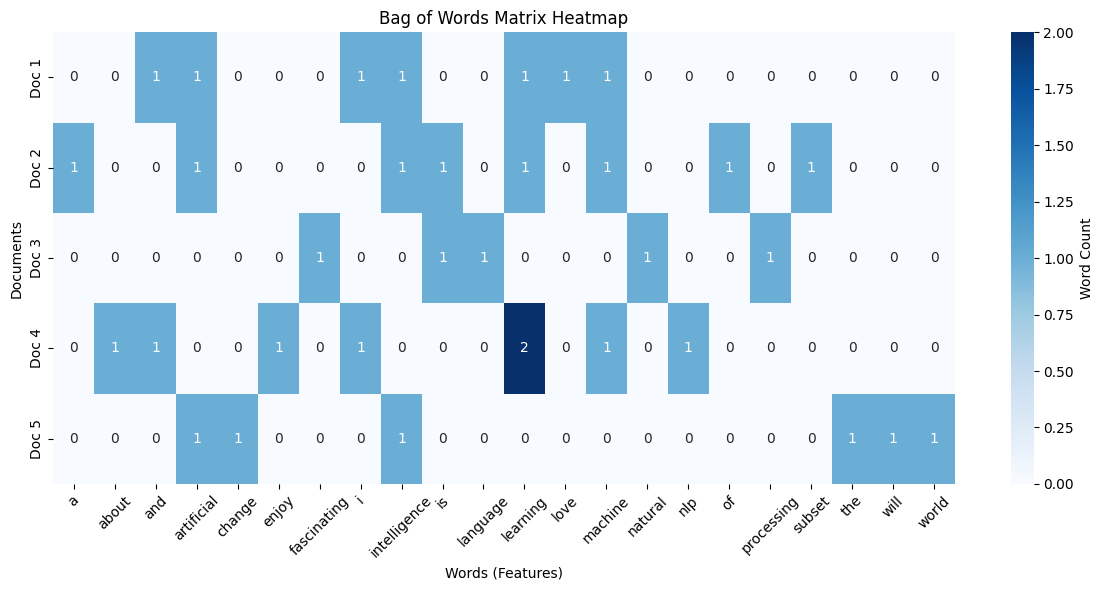


Top 10 most frequent words:
            Word  Total_Frequency
11      learning                4
3     artificial                3
8   intelligence                3
13       machine                3
2            and                2
7              i                2
9             is                2
14       natural                1
20          will                1
19           the                1


In [8]:
# Method 2: Using Scikit-learn CountVectorizer
print("\n\nSCIKIT-LEARN BAG OF WORDS:")
print("=" * 50)

# Basic CountVectorizer
vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
bow_sklearn = vectorizer.fit_transform(sample_texts)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Matrix shape: {bow_sklearn.shape}")
print(f"Matrix type: {type(bow_sklearn)} (sparse matrix)")

# Convert to dense for visualization
bow_dense = bow_sklearn.toarray()

# Create DataFrame for better visualization
feature_names = vectorizer.get_feature_names_out()
df_sklearn = pd.DataFrame(bow_dense, 
                         columns=feature_names,
                         index=[f"Doc {i+1}" for i in range(len(sample_texts))])

print("\nFull BoW Matrix:")
print(df_sklearn)

# Visualize the BoW matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df_sklearn, annot=True, cmap='Blues', fmt='d', cbar_kws={'label': 'Word Count'})
plt.title('Bag of Words Matrix Heatmap')
plt.xlabel('Words (Features)')
plt.ylabel('Documents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show word frequencies across all documents
word_freq = np.sum(bow_dense, axis=0)
freq_df = pd.DataFrame({
    'Word': feature_names,
    'Total_Frequency': word_freq
}).sort_values('Total_Frequency', ascending=False)

print(f"\nTop 10 most frequent words:")
print(freq_df.head(10))

## 3. TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF improves upon Bag of Words by weighting terms based on their importance across the entire document collection.

### The Formula:
**TF-IDF(t,d) = TF(t,d) × IDF(t)**

Where:
- **TF(t,d)** = Term Frequency = (Number of times term t appears in document d) / (Total number of terms in document d)
- **IDF(t)** = Inverse Document Frequency = log(Total number of documents / Number of documents containing term t)

### Why TF-IDF is better than BoW:
- **Reduces impact of common words**: Words appearing in many documents get lower weights
- **Highlights distinctive words**: Rare words that appear in few documents get higher weights
- **Better for similarity**: More meaningful document comparisons
- **Balances frequency**: Very frequent words don't dominate

### Example:
If "machine" appears in all 5 documents, it gets a low IDF score.  
If "fascinating" appears in only 1 document, it gets a high IDF score.

In [9]:
# TF-IDF Implementation

# Method 1: Manual TF-IDF implementation
class SimpleTFIDF:
    def __init__(self):
        self.vocabulary = {}
        self.idf_values = {}
        self.vocab_size = 0
    
    def fit(self, documents):
        """Calculate IDF values for all words."""
        # Build vocabulary
        vocab_set = set()
        for doc in documents:
            words = set(doc.lower().split())  # unique words per document
            vocab_set.update(words)
        
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(vocab_set))}
        self.vocab_size = len(self.vocabulary)
        
        # Calculate IDF for each word
        N = len(documents)  # total documents
        for word in self.vocabulary:
            # Count documents containing this word
            df = sum(1 for doc in documents if word in doc.lower().split())
            # Calculate IDF
            self.idf_values[word] = np.log(N / df)
        
        return self
    
    def transform(self, documents):
        """Transform documents to TF-IDF vectors."""
        vectors = []
        for doc in documents:
            vector = [0.0] * self.vocab_size
            words = doc.lower().split()
            doc_length = len(words)
            
            # Calculate TF for each word in vocabulary
            word_counts = Counter(words)
            
            for word, idx in self.vocabulary.items():
                if word in word_counts:
                    tf = word_counts[word] / doc_length  # Term frequency
                    idf = self.idf_values[word]  # Inverse document frequency
                    vector[idx] = tf * idf  # TF-IDF score
            
            vectors.append(vector)
        return np.array(vectors)
    
    def fit_transform(self, documents):
        """Fit vocabulary and transform documents."""
        return self.fit(documents).transform(documents)

# Test our manual TF-IDF
print("MANUAL TF-IDF IMPLEMENTATION:")
print("=" * 50)

simple_tfidf = SimpleTFIDF()
tfidf_matrix = simple_tfidf.fit_transform(sample_texts)

print(f"Vocabulary size: {simple_tfidf.vocab_size}")
print(f"Matrix shape: {tfidf_matrix.shape}")

# Show some IDF values
print("\nIDF Values (sample words):")
sample_words = list(simple_tfidf.vocabulary.keys())[:8]
for word in sample_words:
    idf_val = simple_tfidf.idf_values[word]
    print(f"  {word}: {idf_val:.3f}")

print(f"\nTF-IDF Matrix (first 3 documents, first 6 features):")
vocab_list = list(simple_tfidf.vocabulary.keys())
df_tfidf = pd.DataFrame(tfidf_matrix[:3, :6], 
                       columns=vocab_list[:6],
                       index=[f"Doc {i+1}" for i in range(3)])
print(df_tfidf.round(3))

MANUAL TF-IDF IMPLEMENTATION:
Vocabulary size: 22
Matrix shape: (5, 22)

IDF Values (sample words):
  a: 1.609
  about: 1.609
  and: 0.916
  artificial: 0.511
  change: 1.609
  enjoy: 1.609
  fascinating: 1.609
  i: 0.916

TF-IDF Matrix (first 3 documents, first 6 features):
           a  about    and  artificial  change  enjoy
Doc 1  0.000    0.0  0.131       0.073     0.0    0.0
Doc 2  0.201    0.0  0.000       0.064     0.0    0.0
Doc 3  0.000    0.0  0.000       0.000     0.0    0.0




SCIKIT-LEARN TF-IDF:
Vocabulary size: 22
Matrix shape: (5, 22)

TF-IDF Matrix (showing values > 0):

Doc 1:
  love: 0.494
  and: 0.399
  i: 0.399
  artificial: 0.331
  intelligence: 0.331

Doc 2:
  a: 0.429
  of: 0.429
  subset: 0.429
  is: 0.346
  artificial: 0.287

Doc 3:
  fascinating: 0.464
  language: 0.464
  natural: 0.464
  processing: 0.464
  is: 0.374

Doc 4:
  learning: 0.524
  about: 0.391
  enjoy: 0.391
  nlp: 0.391
  and: 0.315

Doc 5:
  change: 0.452
  the: 0.452
  will: 0.452
  world: 0.452
  artificial: 0.303


COMPARISON: BoW vs TF-IDF (Document 1)
            Word  BoW_Score  TF-IDF_Score
12          love          1         0.494
2            and          1         0.399
7              i          1         0.399
3     artificial          1         0.331
8   intelligence          1         0.331
11      learning          1         0.331
13       machine          1         0.331


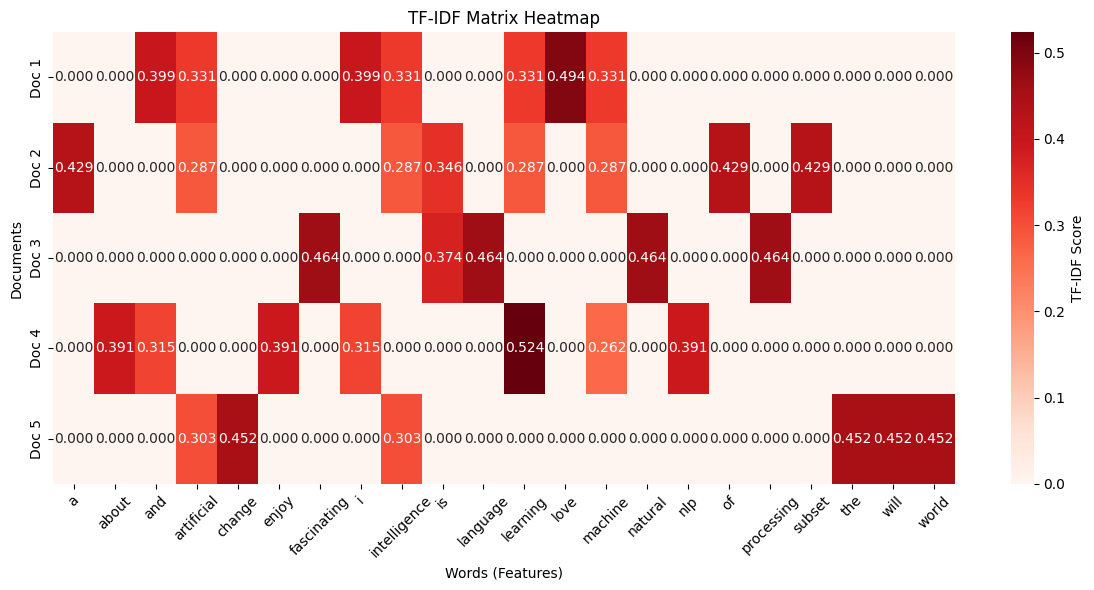

In [10]:
# Method 2: Using Scikit-learn TfidfVectorizer
print("\n\nSCIKIT-LEARN TF-IDF:")
print("=" * 50)

# Basic TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
tfidf_sklearn = tfidf_vectorizer.fit_transform(sample_texts)

print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Matrix shape: {tfidf_sklearn.shape}")

# Convert to dense for visualization
tfidf_dense = tfidf_sklearn.toarray()

# Create DataFrame for better visualization
feature_names = tfidf_vectorizer.get_feature_names_out()
df_tfidf_sklearn = pd.DataFrame(tfidf_dense, 
                               columns=feature_names,
                               index=[f"Doc {i+1}" for i in range(len(sample_texts))])

print("\nTF-IDF Matrix (showing values > 0):")
# Only show non-zero values for clarity
for idx, row in df_tfidf_sklearn.iterrows():
    non_zero = row[row > 0].sort_values(ascending=False)
    print(f"\n{idx}:")
    for word, score in non_zero.head(5).items():
        print(f"  {word}: {score:.3f}")

# Compare BoW vs TF-IDF for the same document
print(f"\n\nCOMPARISON: BoW vs TF-IDF (Document 1)")
print("=" * 50)
doc_idx = 0
bow_scores = df_sklearn.iloc[doc_idx]
tfidf_scores = df_tfidf_sklearn.iloc[doc_idx]

comparison_df = pd.DataFrame({
    'Word': feature_names,
    'BoW_Score': bow_scores.values,
    'TF-IDF_Score': tfidf_scores.values
})

# Show only words with non-zero scores
comparison_df = comparison_df[comparison_df['BoW_Score'] > 0].sort_values('TF-IDF_Score', ascending=False)
print(comparison_df.round(3))

# Visualize TF-IDF matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df_tfidf_sklearn, annot=True, cmap='Reds', fmt='.3f', 
            cbar_kws={'label': 'TF-IDF Score'})
plt.title('TF-IDF Matrix Heatmap')
plt.xlabel('Words (Features)')
plt.ylabel('Documents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. N-grams: Capturing Context and Sequences

N-grams extend BoW and TF-IDF by considering sequences of words instead of treating each word independently.

### Types of N-grams:
- **Unigrams (1-gram)**: Individual words → "machine", "learning"
- **Bigrams (2-gram)**: Pairs of consecutive words → "machine learning", "artificial intelligence"  
- **Trigrams (3-gram)**: Three consecutive words → "machine learning algorithms"
- **N-grams**: Sequences of N consecutive words

### Why N-grams are useful:
- **Capture context**: "not good" vs "good" - bigrams preserve meaning
- **Phrase recognition**: "New York", "machine learning" as single concepts
- **Improved accuracy**: Better performance in many NLP tasks
- **Semantic relationships**: Word order matters in language

### Trade-offs:
- **Pros**: Better context, improved accuracy, phrase recognition
- **Cons**: Higher dimensionality, sparsity increases, more memory needed

In [7]:
# N-grams Implementation

# Manual N-gram extraction
def extract_ngrams(text, n):
    """Extract n-grams from text."""
    words = text.lower().split()
    ngrams = []
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i+n])
        ngrams.append(ngram)
    return ngrams

# Demonstrate n-gram extraction
sample_sentence = "I love machine learning and artificial intelligence"
print("N-GRAMS EXTRACTION:")
print("=" * 50)
print(f"Original text: '{sample_sentence}'")

for n in range(1, 4):
    ngrams = extract_ngrams(sample_sentence, n)
    print(f"\n{n}-grams:")
    print(f"  {ngrams}")

# Compare different n-gram approaches
print(f"\n\nN-GRAMS WITH SCIKIT-LEARN:")
print("=" * 50)

# Test different n-gram ranges
ngram_configs = [
    (1, 1, "Unigrams only"),
    (2, 2, "Bigrams only"), 
    (1, 2, "Unigrams + Bigrams"),
    (1, 3, "Unigrams + Bigrams + Trigrams")
]

for min_n, max_n, description in ngram_configs:
    print(f"\n{description} ({min_n}, {max_n}):")
    
    vectorizer = CountVectorizer(ngram_range=(min_n, max_n), lowercase=True)
    ngram_matrix = vectorizer.fit_transform(sample_texts)
    
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Matrix shape: {ngram_matrix.shape}")
    
    # Show some example features
    feature_names = vectorizer.get_feature_names_out()
    print(f"  Sample features: {feature_names[:8].tolist()}")

# Detailed analysis with bigrams
print(f"\n\nBIGRAM ANALYSIS:")
print("=" * 50)

bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), lowercase=True)
bigram_matrix = bigram_vectorizer.fit_transform(sample_texts)
bigram_features = bigram_vectorizer.get_feature_names_out()

print(f"All bigrams found: {len(bigram_features)}")
print(f"Bigrams: {bigram_features.tolist()}")

# Create DataFrame for bigram visualization
bigram_dense = bigram_matrix.toarray()
df_bigrams = pd.DataFrame(bigram_dense, 
                         columns=bigram_features,
                         index=[f"Doc {i+1}" for i in range(len(sample_texts))])

print(f"\nBigram Matrix:")
print(df_bigrams)

# Show most common bigrams
bigram_freq = np.sum(bigram_dense, axis=0)
bigram_freq_df = pd.DataFrame({
    'Bigram': bigram_features,
    'Frequency': bigram_freq
}).sort_values('Frequency', ascending=False)

print(f"\nMost frequent bigrams:")
print(bigram_freq_df[bigram_freq_df['Frequency'] > 0])

N-GRAMS EXTRACTION:
Original text: 'I love machine learning and artificial intelligence'

1-grams:
  ['i', 'love', 'machine', 'learning', 'and', 'artificial', 'intelligence']

2-grams:
  ['i love', 'love machine', 'machine learning', 'learning and', 'and artificial', 'artificial intelligence']

3-grams:
  ['i love machine', 'love machine learning', 'machine learning and', 'learning and artificial', 'and artificial intelligence']


N-GRAMS WITH SCIKIT-LEARN:

Unigrams only (1, 1):
  Vocabulary size: 20
  Matrix shape: (5, 20)
  Sample features: ['about', 'and', 'artificial', 'change', 'enjoy', 'fascinating', 'intelligence', 'is']

Bigrams only (2, 2):
  Vocabulary size: 22
  Matrix shape: (5, 22)
  Sample features: ['about nlp', 'and artificial', 'and machine', 'artificial intelligence', 'change the', 'enjoy learning', 'intelligence will', 'is fascinating']

Unigrams + Bigrams (1, 2):
  Vocabulary size: 42
  Matrix shape: (5, 42)
  Sample features: ['about', 'about nlp', 'and', 'and art

In [8]:
# N-grams with TF-IDF
print(f"\n\nN-GRAMS + TF-IDF COMBINATION:")
print("=" * 50)

# TF-IDF with different n-gram ranges
tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1))
tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2))
tfidf_combined = TfidfVectorizer(ngram_range=(1, 2))

vectorizers = [
    (tfidf_unigram, "Unigrams TF-IDF"),
    (tfidf_bigram, "Bigrams TF-IDF"),
    (tfidf_combined, "Unigrams+Bigrams TF-IDF")
]

for vectorizer, name in vectorizers:
    matrix = vectorizer.fit_transform(sample_texts)
    features = vectorizer.get_feature_names_out()
    
    print(f"\n{name}:")
    print(f"  Features: {len(features)}")
    print(f"  Shape: {matrix.shape}")
    print(f"  Sample features: {features[:5].tolist()}")
    
    # Show top TF-IDF scores for first document
    dense_matrix = matrix.toarray()
    doc_scores = dense_matrix[0]  # First document
    
    # Get indices of top scores
    top_indices = np.argsort(doc_scores)[-5:][::-1]  # Top 5
    print(f"  Top features for Doc 1:")
    for idx in top_indices:
        if doc_scores[idx] > 0:
            print(f"    {features[idx]}: {doc_scores[idx]:.3f}")

# Practical example: Sentiment-aware n-grams
sentiment_texts = [
    "This movie is not good at all",
    "This movie is very good", 
    "I do not like this movie",
    "I really like this movie"
]

print(f"\n\nSENTIMENT EXAMPLE - Why N-grams Matter:")
print("=" * 60)

# Compare unigrams vs bigrams for sentiment
unigram_vec = CountVectorizer(ngram_range=(1, 1))
bigram_vec = CountVectorizer(ngram_range=(1, 2))

unigram_sentiment = unigram_vec.fit_transform(sentiment_texts)
bigram_sentiment = bigram_vec.fit_transform(sentiment_texts)

print("Sentiment texts:")
for i, text in enumerate(sentiment_texts, 1):
    print(f"  {i}. '{text}'")

print(f"\nUnigrams features: {unigram_vec.get_feature_names_out().tolist()}")
print(f"Unigrams+Bigrams features: {bigram_vec.get_feature_names_out().tolist()}")

# Show how "not good" bigram captures different meaning than separate "not" and "good"
print(f"\nKey insight: 'not good' as bigram vs separate 'not' and 'good' words")
print("This is why n-grams are crucial for sentiment analysis!")



N-GRAMS + TF-IDF COMBINATION:

Unigrams TF-IDF:
  Features: 20
  Shape: (5, 20)
  Sample features: ['about', 'and', 'artificial', 'change', 'enjoy']
  Top features for Doc 1:
    love: 0.539
    and: 0.435
    machine: 0.361
    learning: 0.361
    intelligence: 0.361

Bigrams TF-IDF:
  Features: 22
  Shape: (5, 22)
  Sample features: ['about nlp', 'and artificial', 'and machine', 'artificial intelligence', 'change the']
  Top features for Doc 1:
    learning and: 0.507
    love machine: 0.507
    and artificial: 0.507
    machine learning: 0.339
    artificial intelligence: 0.339

Unigrams+Bigrams TF-IDF:
  Features: 42
  Shape: (5, 42)
  Sample features: ['about', 'about nlp', 'and', 'and artificial', 'and machine']
  Top features for Doc 1:
    love: 0.369
    love machine: 0.369
    and artificial: 0.369
    learning and: 0.369
    and: 0.298


SENTIMENT EXAMPLE - Why N-grams Matter:
Sentiment texts:
  1. 'This movie is not good at all'
  2. 'This movie is very good'
  3. 'I do n

## 5. Comparison: When to Use Which Method?

Let's compare all the text representation methods we've learned and understand when to use each one.

### Summary of Methods:

| Method | Pros | Cons | Best Use Cases |
|--------|------|------|----------------|
| **BoW** | Simple, fast, interpretable | Ignores word order, sparse | Document classification, topic modeling |
| **TF-IDF** | Weights important words, reduces common word impact | Still ignores word order | Information retrieval, document similarity |
| **N-grams** | Captures context, preserves phrases | High dimensionality, sparsity | Sentiment analysis, language modeling |
| **N-grams + TF-IDF** | Best of both worlds | Highest dimensionality | Advanced text classification |

### Decision Guide:
- **Speed is crucial** → BoW
- **Document similarity/search** → TF-IDF  
- **Context matters** → N-grams
- **Maximum accuracy** → N-grams + TF-IDF

In [9]:
# Comprehensive Comparison of All Methods

# Prepare comparison data
comparison_texts = [
    "The movie was absolutely terrible and boring",
    "I found the movie very entertaining and exciting", 
    "Machine learning algorithms are fascinating",
    "Deep learning is a subset of machine learning",
    "Natural language processing helps computers understand text"
]

print("COMPREHENSIVE METHOD COMPARISON")
print("=" * 60)

# Create all vectorizers
vectorizers = {
    'BoW': CountVectorizer(),
    'TF-IDF': TfidfVectorizer(),
    'BoW + Bigrams': CountVectorizer(ngram_range=(1, 2)),
    'TF-IDF + Bigrams': TfidfVectorizer(ngram_range=(1, 2))
}

# Compare all methods
results = {}
for name, vectorizer in vectorizers.items():
    matrix = vectorizer.fit_transform(comparison_texts)
    features = vectorizer.get_feature_names_out()
    
    results[name] = {
        'matrix': matrix,
        'features': features,
        'vectorizer': vectorizer
    }
    
    print(f"\n{name}:")
    print(f"  Vocabulary size: {len(features)}")
    print(f"  Matrix shape: {matrix.shape}")
    print(f"  Matrix sparsity: {1 - (matrix.nnz / (matrix.shape[0] * matrix.shape[1])):.2%}")

# Document similarity comparison
print(f"\n\nDOCUMENT SIMILARITY COMPARISON:")
print("=" * 60)

# Compare how similar Doc 1 and Doc 2 are using different methods
doc1_idx, doc2_idx = 0, 1  # "terrible" vs "entertaining" movies

print(f"Document 1: '{comparison_texts[doc1_idx]}'")
print(f"Document 2: '{comparison_texts[doc2_idx]}'")
print(f"Expected: These should be dissimilar (opposite sentiment)")

for name, data in results.items():
    matrix = data['matrix'].toarray()
    
    # Calculate cosine similarity between documents
    doc1_vector = matrix[doc1_idx:doc1_idx+1]
    doc2_vector = matrix[doc2_idx:doc2_idx+1]
    
    similarity = cosine_similarity(doc1_vector, doc2_vector)[0][0]
    print(f"\n{name} similarity: {similarity:.3f}")

# Feature importance comparison
print(f"\n\nFEATURE IMPORTANCE COMPARISON (Document 1):")
print("=" * 60)

doc_idx = 0  # First document
for name, data in results.items():
    matrix = data['matrix'].toarray()
    features = data['features']
    
    doc_vector = matrix[doc_idx]
    
    # Get top features
    top_indices = np.argsort(doc_vector)[-5:][::-1]
    
    print(f"\n{name} - Top features:")
    for idx in top_indices:
        if doc_vector[idx] > 0:
            print(f"  {features[idx]}: {doc_vector[idx]:.3f}")

# Practical recommendation system example
print(f"\n\nPRACTICAL EXAMPLE: DOCUMENT RECOMMENDATION")
print("=" * 60)

query = "I love machine learning and AI"
print(f"Query: '{query}'")

# Find most similar document using TF-IDF
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(comparison_texts + [query])

# Calculate similarities between query and all documents
query_vector = tfidf_matrix[-1:]  # Last row (query)
doc_vectors = tfidf_matrix[:-1]  # All documents except query

similarities = cosine_similarity(query_vector, doc_vectors)[0]

# Rank documents by similarity
doc_rankings = [(i, sim) for i, sim in enumerate(similarities)]
doc_rankings.sort(key=lambda x: x[1], reverse=True)

print(f"\nDocument rankings (most to least similar):")
for rank, (doc_idx, similarity) in enumerate(doc_rankings, 1):
    print(f"{rank}. Similarity: {similarity:.3f} - '{comparison_texts[doc_idx]}'")

# Memory and computation comparison
print(f"\n\nCOMPUTATIONAL COMPARISON:")
print("=" * 60)

import time
from scipy.sparse import issparse

large_texts = comparison_texts * 100  # Simulate larger dataset

for name, vectorizer in vectorizers.items():
    start_time = time.time()
    matrix = vectorizer.fit_transform(large_texts)
    end_time = time.time()
    
    memory_mb = matrix.data.nbytes / (1024**2) if issparse(matrix) else matrix.nbytes / (1024**2)
    
    print(f"\n{name}:")
    print(f"  Processing time: {end_time - start_time:.3f} seconds")
    print(f"  Memory usage: {memory_mb:.2f} MB")
    print(f"  Features: {len(vectorizer.get_feature_names_out())}")

COMPREHENSIVE METHOD COMPARISON

BoW:
  Vocabulary size: 27
  Matrix shape: (5, 27)
  Matrix sparsity: 76.30%

TF-IDF:
  Vocabulary size: 27
  Matrix shape: (5, 27)
  Matrix sparsity: 76.30%

BoW + Bigrams:
  Vocabulary size: 53
  Matrix shape: (5, 53)
  Matrix sparsity: 77.36%

TF-IDF + Bigrams:
  Vocabulary size: 53
  Matrix shape: (5, 53)
  Matrix sparsity: 77.36%


DOCUMENT SIMILARITY COMPARISON:
Document 1: 'The movie was absolutely terrible and boring'
Document 2: 'I found the movie very entertaining and exciting'
Expected: These should be dissimilar (opposite sentiment)

BoW similarity: 0.429

TF-IDF similarity: 0.328

BoW + Bigrams similarity: 0.308

TF-IDF + Bigrams similarity: 0.224


FEATURE IMPORTANCE COMPARISON (Document 1):

BoW - Top features:
  was: 1.000
  terrible: 1.000
  the: 1.000
  movie: 1.000
  boring: 1.000

TF-IDF - Top features:
  was: 0.410
  terrible: 0.410
  absolutely: 0.410
  boring: 0.410
  and: 0.331

BoW + Bigrams - Top features:
  was absolutely: 1.0

## 6. Practical Exercises and Real-World Applications

### Try These Exercises:

1. **Document Classification**: Use different vectorization methods to classify documents
2. **Search Engine**: Build a simple search engine using TF-IDF
3. **Sentiment Analysis**: Compare how well different methods capture sentiment
4. **Recommendation System**: Find similar documents based on text content

Let's implement a simple document search engine to put everything together!

In [10]:
# Practical Application: Simple Search Engine

class SimpleSearchEngine:
    """A simple search engine using TF-IDF vectorization."""
    
    def __init__(self, use_bigrams=True):
        if use_bigrams:
            self.vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
        else:
            self.vectorizer = TfidfVectorizer(stop_words='english')
        
        self.documents = []
        self.document_matrix = None
        self.is_fitted = False
    
    def add_documents(self, documents):
        """Add documents to the search index."""
        self.documents = documents
        self.document_matrix = self.vectorizer.fit_transform(documents)
        self.is_fitted = True
        print(f"✅ Indexed {len(documents)} documents")
        print(f"📊 Vocabulary size: {len(self.vectorizer.vocabulary_)}")
    
    def search(self, query, top_k=3):
        """Search for documents similar to the query."""
        if not self.is_fitted:
            raise ValueError("Search engine not fitted. Call add_documents() first.")
        
        # Vectorize the query
        query_vector = self.vectorizer.transform([query])
        
        # Calculate similarities
        similarities = cosine_similarity(query_vector, self.document_matrix)[0]
        
        # Get top-k most similar documents
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        
        results = []
        for i, idx in enumerate(top_indices):
            results.append({
                'rank': i + 1,
                'document': self.documents[idx],
                'similarity': similarities[idx],
                'doc_index': idx
            })
        
        return results
    
    def explain_search(self, query, doc_index):
        """Explain why a document matched the query."""
        query_vector = self.vectorizer.transform([query])
        doc_vector = self.document_matrix[doc_index:doc_index+1]
        
        # Get feature names
        features = self.vectorizer.get_feature_names_out()
        
        # Get non-zero features in query and document
        query_features = set(np.where(query_vector.toarray()[0] > 0)[0])
        doc_features = set(np.where(doc_vector.toarray()[0] > 0)[0])
        
        # Find matching features
        matching_features = query_features.intersection(doc_features)
        
        print(f"🔍 Query: '{query}'")
        print(f"📄 Document: '{self.documents[doc_index][:100]}...'")
        print(f"🎯 Matching features ({len(matching_features)}):")
        
        for feature_idx in sorted(matching_features):
            feature_name = features[feature_idx]
            query_weight = query_vector.toarray()[0][feature_idx]
            doc_weight = doc_vector.toarray()[0][feature_idx]
            print(f"   {feature_name}: query={query_weight:.3f}, doc={doc_weight:.3f}")

# Create a sample document collection
documents = [
    "Machine learning algorithms can automatically improve through experience and data",
    "Deep learning is a subset of machine learning using artificial neural networks", 
    "Natural language processing helps computers understand human language",
    "Computer vision enables machines to interpret visual information from images",
    "Artificial intelligence aims to create systems that can perform human-like tasks",
    "Data science combines statistics, programming, and domain knowledge",
    "Python is a popular programming language for machine learning and data analysis",
    "Neural networks are inspired by the structure of the human brain",
    "Big data analytics helps organizations extract insights from large datasets",
    "Reinforcement learning teaches agents to make decisions through trial and error"
]

print("🔍 SIMPLE SEARCH ENGINE DEMO")
print("=" * 60)

# Create and setup search engine
search_engine = SimpleSearchEngine(use_bigrams=True)
search_engine.add_documents(documents)

# Test searches
test_queries = [
    "machine learning algorithms",
    "neural networks and deep learning", 
    "natural language processing",
    "data analysis with Python"
]

for query in test_queries:
    print(f"\n🔍 Search Query: '{query}'")
    print("-" * 40)
    
    results = search_engine.search(query, top_k=3)
    
    for result in results:
        print(f"{result['rank']}. Similarity: {result['similarity']:.3f}")
        print(f"   Document: {result['document'][:80]}...")
    
    # Explain the top result
    if results[0]['similarity'] > 0:
        print(f"\n💡 Why this document matched:")
        search_engine.explain_search(query, results[0]['doc_index'])
        
    print()

print("=" * 60)
print("🎉 Search engine demo completed!")
print("\n💡 Try modifying the queries or documents to see how results change!")

🔍 SIMPLE SEARCH ENGINE DEMO
✅ Indexed 10 documents
📊 Vocabulary size: 127

🔍 Search Query: 'machine learning algorithms'
----------------------------------------
1. Similarity: 0.568
   Document: Machine learning algorithms can automatically improve through experience and dat...
2. Similarity: 0.274
   Document: Deep learning is a subset of machine learning using artificial neural networks...
3. Similarity: 0.233
   Document: Python is a popular programming language for machine learning and data analysis...

💡 Why this document matched:
🔍 Query: 'machine learning algorithms'
📄 Document: 'Machine learning algorithms can automatically improve through experience and data...'
🎯 Matching features (5):
   algorithms: query=0.531, doc=0.302
   learning: query=0.351, doc=0.200
   learning algorithms: query=0.531, doc=0.302
   machine: query=0.395, doc=0.224
   machine learning: query=0.395, doc=0.224


🔍 Search Query: 'neural networks and deep learning'
----------------------------------------

## 7. Key Takeaways and Next Steps

### 🎯 What We Learned:

1. **Text to Numbers**: Why and how to convert text into numerical representations
2. **Bag of Words (BoW)**: Simple word counting approach
   - Fast and interpretable
   - Good for basic classification tasks
3. **TF-IDF**: Weighted approach that highlights important words
   - Better than BoW for document similarity
   - Reduces impact of common words
4. **N-grams**: Capturing context and word sequences
   - Essential for sentiment analysis
   - Better accuracy but higher dimensionality
5. **Method Selection**: How to choose the right approach for your task

### 🛠️ Practical Skills Gained:
- ✅ Manual implementation of vectorization methods
- ✅ Using scikit-learn for efficient text processing
- ✅ Comparing different approaches objectively
- ✅ Building a simple search engine
- ✅ Understanding trade-offs between methods

### 🎯 When to Use Each Method:

| Task Type | Recommended Method | Why |
|-----------|-------------------|-----|
| **Document Classification** | TF-IDF or BoW + N-grams | Good balance of speed and accuracy |
| **Information Retrieval** | TF-IDF | Excellent for finding relevant documents |
| **Sentiment Analysis** | N-grams + TF-IDF | Context matters for sentiment |
| **Topic Modeling** | TF-IDF | Helps identify distinctive topics |
| **Quick Prototyping** | BoW | Fast and simple |

### 🚀 Next Steps:

In the next notebook (`03-pos-tagging-parsing.ipynb`), we'll explore:
- **Part-of-Speech (POS) Tagging**: Understanding grammatical roles
- **Named Entity Recognition (NER)**: Identifying people, places, organizations
- **Dependency Parsing**: Understanding sentence structure
- **Practical applications** of linguistic analysis

### 💡 Practice Exercises:
1. **Try different datasets**: Apply these methods to your own text data
2. **Experiment with parameters**: Change n-gram ranges, min/max document frequency
3. **Build applications**: Create a simple document classifier or search engine
4. **Compare results**: Test how preprocessing affects vectorization quality

### 📚 Key Libraries Mastered:
- `sklearn.feature_extraction.text.CountVectorizer`
- `sklearn.feature_extraction.text.TfidfVectorizer`
- `sklearn.metrics.pairwise.cosine_similarity`

**Remember**: The best representation method depends on your specific task and data. Always experiment and evaluate!